# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pickle import dump,load

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.optimizers import Adam

from keras.callbacks import EarlyStopping,ModelCheckpoint

#from keras.utils import plot_model
from keras.models import Model,load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.layers.merge import add
from nltk.translate.bleu_score import corpus_bleu
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/priya/opt/anaconda3/lib/python3.7/sit

## Load the cleaned descriptions

In [3]:
# Load the cleaned descriptions

train_descriptions = load(open("./saved_data/train_descriptions.pkl","rb"))
dev_descriptions = load(open("./saved_data/dev_descriptions.pkl","rb"))
test_descriptions = load(open("./saved_data/test_descriptions.pkl","rb"))

Our captions are in text format and we need to map these words to an unique integer values, for model to understand.

For this, I have used the **Keras Tokenizer class**, which can map each word to unique integer value.

In [4]:
# Create the tokenizer

def create_token(descriptions):
    
    # Create an empty list to store the descriptions text
    lines = list()
    
    for key in descriptions.keys():
        [lines.append(values) for values in descriptions[key]]
    
    total_images_to_train = len(lines)
        
    maximum_length = max(len(d.split()) for d in lines)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return total_images_to_train,maximum_length,tokenizer

In [5]:
# prepare tokenizer

total_images_to_train, maximum_length, tokenizer = create_token(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

print('Vocabulary Size: ',vocab_size)
print('Maximum length of description: ',maximum_length)
print('Total images for training: ', total_images_to_train)

Vocabulary Size:  7581
Maximum length of description:  34
Total images for training:  30000


In [6]:
# What does the tokenizer do
tokenizer.index_word #How the words are assigned to an unique integer values

{1: 'startseq',
 2: 'endseq',
 3: 'in',
 4: 'the',
 5: 'on',
 6: 'is',
 7: 'and',
 8: 'dog',
 9: 'with',
 10: 'man',
 11: 'of',
 12: 'two',
 13: 'white',
 14: 'black',
 15: 'boy',
 16: 'are',
 17: 'woman',
 18: 'girl',
 19: 'to',
 20: 'wearing',
 21: 'at',
 22: 'people',
 23: 'water',
 24: 'brown',
 25: 'red',
 26: 'young',
 27: 'an',
 28: 'his',
 29: 'blue',
 30: 'dogs',
 31: 'running',
 32: 'through',
 33: 'playing',
 34: 'while',
 35: 'down',
 36: 'shirt',
 37: 'ball',
 38: 'standing',
 39: 'little',
 40: 'grass',
 41: 'snow',
 42: 'child',
 43: 'person',
 44: 'jumping',
 45: 'over',
 46: 'three',
 47: 'sitting',
 48: 'front',
 49: 'field',
 50: 'holding',
 51: 'small',
 52: 'yellow',
 53: 'green',
 54: 'group',
 55: 'by',
 56: 'up',
 57: 'large',
 58: 'one',
 59: 'walking',
 60: 'her',
 61: 'men',
 62: 'children',
 63: 'air',
 64: 'into',
 65: 'near',
 66: 'mouth',
 67: 'beach',
 68: 'jumps',
 69: 'runs',
 70: 'another',
 71: 'for',
 72: 'street',
 73: 'from',
 74: 'its',
 75: 'rid

In [7]:
# What does the tokenizer do
tokenizer.word_counts # shows the number of times a word has occurred

OrderedDict([('startseq', 30000),
             ('black', 2854),
             ('dog', 6158),
             ('is', 6904),
             ('running', 1587),
             ('after', 145),
             ('white', 2921),
             ('in', 14083),
             ('the', 13508),
             ('snow', 1173),
             ('endseq', 30000),
             ('chasing', 144),
             ('brown', 1995),
             ('through', 1533),
             ('two', 4246),
             ('dogs', 1618),
             ('chase', 29),
             ('each', 318),
             ('other', 566),
             ('across', 353),
             ('snowy', 318),
             ('ground', 274),
             ('play', 576),
             ('together', 315),
             ('low', 54),
             ('lying', 69),
             ('body', 142),
             ('of', 4964),
             ('water', 2024),
             ('little', 1266),
             ('baby', 322),
             ('plays', 392),
             ('croquet', 5),
             ('girl', 2414),
   

In [8]:
# Load the image_features extracted by Inceptionv3 and ResNet models.

train_image_extracted = np.load('./saved_data/train_image_extracted_inception.npy',allow_pickle='TRUE').item()
dev_image_extracted = np.load('./saved_data/dev_image_extracted_inception.npy',allow_pickle='TRUE').item()
test_image_extracted = np.load('./saved_data/test_image_extracted_inception.npy',allow_pickle='TRUE').item()

# Print 1st row of each to see if they are loaded properly
print("Sample of train image features")
print({k:v for k,v in list(train_image_extracted.items())[:1]})
print("\nSample of dev image features")
print({k:v for k,v in list(dev_image_extracted.items())[:1]})
print("\nSample of test image features")
print({k:v for k,v in list(test_image_extracted.items())[:1]})

Sample of train image features
{'2513260012_03d33305cf.jpg': array([0.08447927, 0.09467603, 0.09230011, ..., 0.0769059 , 1.4561858 ,
       0.45119157], dtype=float32)}

Sample of dev image features
{'2090545563_a4e66ec76b.jpg': array([0.05215571, 0.49605808, 0.7101982 , ..., 1.0289909 , 0.03897632,
       0.17930922], dtype=float32)}

Sample of test image features
{'3385593926_d3e9c21170.jpg': array([0.24057272, 0.13829081, 0.25790066, ..., 0.522944  , 1.2534735 ,
       0.52420866], dtype=float32)}


# Create sequence for each caption.

This is helpful in creating the input-output pairs of data required for training the model.

So, this function takes caption's array and image feature's array, and then outputs a word, which is the encoded next word in the text sequence.

This function to create_sequence, will take :<br>
**input :** tokenizer, maximum_length, descriptions(a dictionary) , image_features(a dictionary) , vocabulary_size<br>
**output :** encoded next word in sequence

_pad_sequences_ is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.

![""](./images/text_to_sequence.png)



In [9]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, 
                     descriptions, photos, vocab_size):
    
    # set a counter, to show the output for only 1 image
    n = 0
    
    #photos is features extracted
    X1, X2, y = list(), list(), list()
    
    # walk through each image identifier
    for key, values in descriptions.items():
        
        # walk through each description for the image
        for desc in values:
            #print(desc)

            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            
            if n==0: 
                print("Text is : \n{}\ntext_to_sequence is: \n{}\n".format(desc,seq))
                print('Length of sequence is {}'.format(len(seq)))
                print("------------------------------------------------------------")
            
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                
                # pad input sequence
                in_seq_1 = pad_sequences([in_seq], maxlen=maximum_length)[0]
                
                # encode output sequence
                out_seq_1 = to_categorical([out_seq], num_classes=vocab_size)[0]
                
                #out_seq_1 = to_categorical([out_seq], num_classes=vocab_size)

                if n ==0:

                    print('Input_sequence: {}'.format([tokenizer.index_word[in_seq[i]] for i in range(len(in_seq))]))
                    print('Input_sequence: {}'.format(in_seq))
                    print("Output sequence: {}".format(tokenizer.index_word[seq[i]]))
                    print('Output sequence: {}'.format(out_seq))
                    print('Input sequence(after padding):\n{}'.format(in_seq_1))
                    print('Output sequence (after categorical):\n{}\n'.format(out_seq_1))
            
                #X1.append(photos[key][0])
                X1.append(photos[key])
                X2.append(in_seq_1)
                y.append(out_seq_1)
            n+=1
    return np.array(X1), np.array(X2), np.array(y)

In [10]:
# sequence for test image descriptions
X1train, X2train, ytrain = create_sequences(tokenizer, 
                                            maximum_length, 
                                            train_descriptions, 
                                            train_image_extracted,vocab_size)


Text is : 
startseq black dog is running after white dog in the snow endseq
text_to_sequence is: 
[1, 14, 8, 6, 31, 252, 13, 8, 3, 4, 41, 2]

Length of sequence is 12
------------------------------------------------------------
Input_sequence: ['startseq']
Input_sequence: [1]
Output sequence: black
Output sequence: 14
Input sequence(after padding):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Output sequence (after categorical):
[0. 0. 0. ... 0. 0. 0.]

Input_sequence: ['startseq', 'black']
Input_sequence: [1, 14]
Output sequence: dog
Output sequence: 8
Input sequence(after padding):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1 14]
Output sequence (after categorical):
[0. 0. 0. ... 0. 0. 0.]

Input_sequence: ['startseq', 'black', 'dog']
Input_sequence: [1, 14, 8]
Output sequence: is
Output sequence: 6
Input sequence(after padding):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

In [11]:
print("The shape of image (training set) features is: {}".format(X1train.shape))
print("The shape of text (training set) features is: {}".format(X2train.shape))

# There are 7581 unique words in the vocabulary.
print("The shape of next possible word (training set) features is: {}".format(ytrain.shape))


The shape of image (training set) features is: (306374, 2048)
The shape of text (training set) features is: (306374, 34)
The shape of next possible word (training set) features is: (306374, 7581)


In [12]:
X1test, X2test, ytest = create_sequences(tokenizer, 
                                            maximum_length, 
                                            dev_descriptions, 
                                            dev_image_extracted,vocab_size)

Text is : 
startseq the boy laying face down on skateboard is being pushed along the ground by another boy endseq
text_to_sequence is: 
[1, 4, 15, 259, 120, 35, 5, 132, 6, 174, 1703, 113, 4, 163, 55, 70, 15, 2]

Length of sequence is 18
------------------------------------------------------------
Input_sequence: ['startseq']
Input_sequence: [1]
Output sequence: the
Output sequence: 4
Input sequence(after padding):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Output sequence (after categorical):
[0. 0. 0. ... 0. 0. 0.]

Input_sequence: ['startseq', 'the']
Input_sequence: [1, 4]
Output sequence: boy
Output sequence: 15
Input sequence(after padding):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4]
Output sequence (after categorical):
[0. 0. 0. ... 0. 0. 0.]

Input_sequence: ['startseq', 'the', 'boy']
Input_sequence: [1, 4, 15]
Output sequence: laying
Output sequence: 259
Input sequence(after padding):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  

In [13]:
print("The shape of image (development set) features is: {}".format(X1test.shape))
print("The shape of text (development set) features is: {}".format(X2test.shape))

# There are 7581 unique words in the vocabulary.
print("The shape of next possible word (development set) features is: {}".format(ytest.shape))

The shape of image (development set) features is: (50903, 2048)
The shape of text (development set) features is: (50903, 34)
The shape of next possible word (development set) features is: (50903, 7581)


# Define the model for training.

Loss will be "categorical_entropy".<br>

To avoid overfitting the model, model will be validating on the development dataset, and will stop training the model, if validation_loss starts to increase.

**Input to model** : Image_features & encoded sequence (of texts - generated earlier)<br>
**Embedding layer** : Our vocabulary is discrete and by embedding we will be creating a map which will embed each word into a continuous vector space. Using this vector space representation it allow us to have a continuous  representation of our vocabulary words.

The first argument,_vocab_size_ is the number of distinct words in the training set. <br>
The second argument _256_ indicates the size of the embedding vectors. 

Once the network has been trained, we can get the weights of the embedding layer and can be thought as the table used to map integers to embedding vectors.<br>
**Output** : The next predicted word.

!["Overview of model"](./images/merge_model_overview.png)

In [22]:
# define the captioning model 

def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))

    fe1 = Dropout(0.5)(inputs1)

    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(maximum_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    
    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=.0001),metrics=['accuracy'])
    
    # summarize model
    print(model.summary())
    
    return model

In [24]:
#define model

model = define_model(vocab_size, maximum_length)

# define checkpoint callback
filepath = './saved_data/model_inception_ep{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# to stop model training, once validation_loss starts to increase.
early_stops = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=0)

# Fit the model
hist = model.fit([X1train, X2train], ytrain, 
                 epochs=20,
                 batch_size=64, #default is 32
                 verbose=1, 
                 callbacks=[checkpoint,early_stops], 
                 validation_data=([X1test, X2test], ytest))

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 34, 256)      1940736     input_12[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 2048)         0           input_11[0][0]                   
____________________________________________________________________________________________

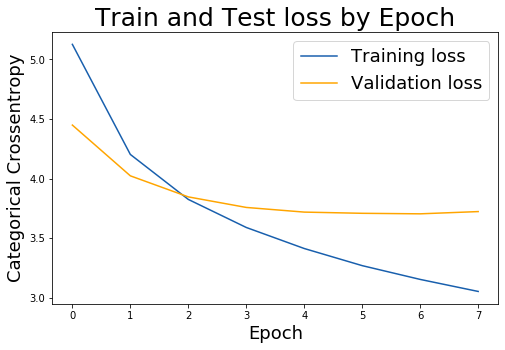

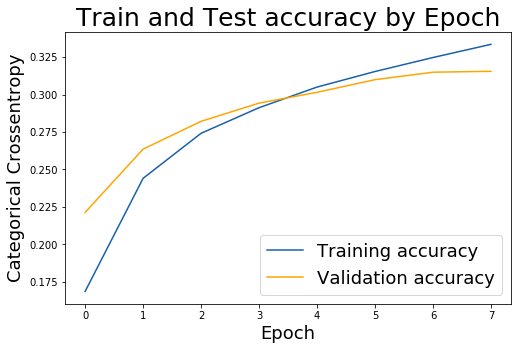

In [28]:
# Plot the loss and accuracy over epochs
def plot_model_history(metric):
    # Set figure size.
    plt.figure(figsize=(8, 5))

    # Generate line plot for loss and accuracy over epochs.
    
    plt.plot(hist.history[metric], label='Training '+metric, color='#185fad')
    plt.plot(hist.history["val_"+metric], label='Validation '+metric, color='orange')

    plt.title('Train and Test '+metric+' by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Categorical Crossentropy', fontsize = 18)

    plt.legend(fontsize = 18);

for metrics in ['loss','accuracy']:
    plot_model_history(metrics)

# Model evaluation

For model evaluation, I have used BLEU metric.

**BLEU score :**<br>
BLEU scores are used in text translation for evaluating translated text against one or more reference translations.
Closer the score to 1, better.


We have to generate the caption for the holdout test images and then compare the generated caption with the original captions.

Here, we compare each generated description against all of the reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.

#### Generating the caption from the trained model

Model will output the probability of next words in sequence, we will take the "integer"(since, words were converted to integers) with maximum probablity and then with the help of tokenizer, will find what word it is.

The model will start predicting as soon as it sees "startseq" and will end prediction once "endseq" is reached.

In [142]:
# Function to find the word per its index from the tokenizer
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

In [143]:
# Generate the description for test data based on best-score model
def generate_description(model, tokenizer, features, maximum_length):
    
    #start generating the description
    input_word = 'startseq' 
    
    # The description shouldn't exceed the maximum length
    for i in range(maximum_length):
        
        # Get the integer code of input_word # Checkkkk
        sequence = tokenizer.texts_to_sequences([input_word])[0]
        
        # pad input
        sequence = pad_sequences([sequence], maxlen=maximum_length)
        
        # predict next word
        features1 = features.reshape(1,len(features))
        predicted_word = model.predict([features1, sequence], verbose=0)
        
        # Convert the probability of integer
        predicted_word =  np.argmax(predicted_word)
        
        # map_int_to_word
        word = index_word[predicted_word]
                    
        #Append as input for generating the next word
        input_word += ' ' + word
        
        # stop if we predict the end of sequence
        if word == 'endseq':
            break
    
    return input_word

In [144]:
def evaluate_model(model, descriptions, features, tokenizer, maximum_length):
    
    # Create empty lists to store the actual and predicted captions
    actual_full_list = []
    predicted_full_list = []
    
    image_name = []
    #actual_final=[]
    predicted_final=[]
    bleu_1gram =[]
    bleu_2gram =[]
    try_actual_final=[]
    
    for key, value in descriptions.items():
        
        actual=[]
        predicted=[]
        
        predicted_caption = generate_description(model, tokenizer, features[key] , maximum_length)
        
        words = [word.split() for word in value]
        actual.append(words)
        actual_full_list.append(words)
        
        predicted.append(predicted_caption.split())
        predicted_full_list.append(predicted_caption.split())
                
        bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
        bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
        
        image_name.append(key)
        #actual_final.append(value)
        try_actual_final.append(".\n".join(value))
        predicted_final.append(predicted_caption)
        bleu_1gram.append(bleu_1)
        bleu_2gram.append(bleu_2)
        
    print('BLEU-1: %f' % corpus_bleu(actual_full_list, predicted_full_list, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual_full_list, predicted_full_list, weights=(0.5, 0.5, 0, 0)))
    
    BLEU_1 = corpus_bleu(actual_full_list, predicted_full_list, weights=(1.0, 0, 0, 0))
    BLEU_2 = corpus_bleu(actual_full_list, predicted_full_list, weights=(1.0, 0, 0, 0))
     
    return image_name,try_actual_final,predicted_final,bleu_1gram,bleu_2gram,BLEU_1,BLEU_2  
    #return bleu_1gram,bleu_1gram

**Load the various saved models to check which has maximum BLEU_score.**

Below are some models that I saved during various run-throughs having the highest BLEU_scores.

When features were extracted using **ResNet**: <br>
1. _model_resnet_ep001_loss5.211_val_loss4.644.h5_ <br>
BLEU-1: 0.554787<br>
BLEU-2: 0.267165


When features were extracted with **Inception** model: <br>
1. _model_inception_ep007_acc0.325_loss3.153_val_acc0.315_val_loss3.704.h5_ <br>
BLEU-1: 0.634139 <br>
BLEU-2: 0.404242 <br>
2. _model_inception_ep006_acc0.315_loss3.269_val_acc0.310_val_loss3.708.h5_ <br>
BLEU-1: 0.624361 <br>
BLEU-2: 0.398340 <br>
3. _model_inception_ep003_acc0.274_loss3.825_val_acc0.282_val_loss3.846.h5_ <br>
BLEU-1: 0.611277 <br>
BLEU-2: 0.377536 <br>
4. _model_inception_ep005_acc0.305_loss3.413_val_acc0.301_val_loss3.718.h5_ <br>
BLEU-1: 0.603911 <br>
BLEU-2: 0.381699



In [33]:
# Calculate the BLEU score for all different models having minimum val_loss.

models_list = [
'model_inception_ep003_acc0.274_loss3.825_val_acc0.282_val_loss3.846.h5',
'model_inception_ep005_acc0.305_loss3.413_val_acc0.301_val_loss3.718.h5',
'model_inception_ep006_acc0.315_loss3.269_val_acc0.310_val_loss3.708.h5',
'model_inception_ep007_acc0.325_loss3.153_val_acc0.315_val_loss3.704.h5'
              ]
for models in models_list:
    model_name = './saved_data/'+models
    print(model_name)
    model = load_model(model_name)
    print(model.summary)
    
    image_name,try_actual_final,predicted_final,bleu_1gram,bleu_2gram,BLEU_1,BLEU_2 = evaluate_model(model, 
                                                                                                test_descriptions, 
                                                                                                test_image_extracted, 
                                                                                                tokenizer, 
                                                                                                maximum_length)
    print('{} model, 1gm score: {}, 2gm score: {}'.format(models,BLEU_1,BLEU_2))

./saved_data/model_inception_ep001_acc0.169_loss5.127_val_acc0.221_val_loss4.449.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x47e2fc510>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.354312
BLEU-2: 0.197152
model_inception_ep001_acc0.169_loss5.127_val_acc0.221_val_loss4.449.h5 model, 1gm score: 0.35431193754097384, 2gm score: 0.35431193754097384
./saved_data/model_inception_ep002_acc0.244_loss4.202_val_acc0.264_val_loss4.023.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x480b4be50>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.585020
BLEU-2: 0.353707
model_inception_ep002_acc0.244_loss4.202_val_acc0.264_val_loss4.023.h5 model, 1gm score: 0.5850196604967872, 2gm score: 0.5850196604967872
./saved_data/model_inception_ep003_acc0.274_loss3.825_val_acc0.282_val_loss3.846.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x488eb3e10>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.611277
BLEU-2: 0.377536
model_inception_ep003_acc0.274_loss3.825_val_acc0.282_val_loss3.846.h5 model, 1gm score: 0.611277108433735, 2gm score: 0.611277108433735
./saved_data/model_inception_ep004_acc0.291_loss3.589_val_acc0.294_val_loss3.757.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x48359a1d0>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.571313
BLEU-2: 0.358432
model_inception_ep004_acc0.291_loss3.589_val_acc0.294_val_loss3.757.h5 model, 1gm score: 0.5713127308766556, 2gm score: 0.5713127308766556
./saved_data/model_inception_ep005_acc0.305_loss3.413_val_acc0.301_val_loss3.718.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x494e7b990>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.603911
BLEU-2: 0.381699
model_inception_ep005_acc0.305_loss3.413_val_acc0.301_val_loss3.718.h5 model, 1gm score: 0.6039112940956302, 2gm score: 0.6039112940956302
./saved_data/model_inception_ep006_acc0.315_loss3.269_val_acc0.310_val_loss3.708.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x4977efa50>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.624361
BLEU-2: 0.398340
model_inception_ep006_acc0.315_loss3.269_val_acc0.310_val_loss3.708.h5 model, 1gm score: 0.6243605829553132, 2gm score: 0.6243605829553132
./saved_data/model_inception_ep007_acc0.325_loss3.153_val_acc0.315_val_loss3.704.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x49de63450>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.634139
BLEU-2: 0.404242
model_inception_ep007_acc0.325_loss3.153_val_acc0.315_val_loss3.704.h5 model, 1gm score: 0.634139121854958, 2gm score: 0.634139121854958


In [146]:
# Load the model with highest BLEU_score and check its predictions

filename = 'model_inception_ep007_acc0.325_loss3.153_val_acc0.315_val_loss3.704.h5'
model = load_model('./saved_data/'+filename)

image_name,try_actual_final,predicted_final,bleu_1gram,bleu_2gram,BLEU_1,BLEU_2 = evaluate_model(model, 
                                                                                                test_descriptions, 
                                                                                                test_image_extracted, 
                                                                                                tokenizer, 
                                                                                                maximum_length)

/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.634139
BLEU-2: 0.404242


In [147]:
# To display the entire row from the dataframe
pd.set_option('display.max_colwidth', -1)

/Users/priya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [148]:
# Create a dataframe
df = pd.DataFrame({'image_name':image_name,
                'bleu_1gram':bleu_1gram,
                'bleu_2gram':bleu_2gram,
                 'try_actual_final':try_actual_final,
                 'predicted_final':predicted_final
                })
df.head()

image_name  bleu_1gram  bleu_2gram  \
0  3385593926_d3e9c21170.jpg  0.555556    0.263523     
1  2677656448_6b7e7702af.jpg  0.495359    0.378337     
2  311146855_0b65fdb169.jpg   0.428571    0.181568     
3  1258913059_07c613f7ff.jpg  0.666667    0.408248     
4  241347760_d44c8d3a01.jpg   0.888889    0.471405     

                                                                                                                                                                                                                                                                                                                                                                                                                       try_actual_final  \
0  startseq the dogs are in the snow in front of fence endseq.\nstartseq the dogs play on the snow endseq.\nstartseq two brown dogs playfully fight in the snow endseq.\nstartseq two brown dogs wrestle in the snow endseq.\nstartseq two dogs playing in the snow endseq                                                                                                                                                                
1  startseq brown and white dog swimming towards some in the pool endseq.\nstartseq dog in swimming pool swims toward sombody we cannot see endseq.\nstartseq dog swims in pool near person endseq.\nstartseq small dog is paddling through the water in pool endseq.\nstartseq the small brown and white dog is in the pool endseq                                                                                                       
2  startseq man and woman in festive costumes dancing endseq.\nstartseq man and woman with feathers on her head dance endseq.\nstartseq man and woman wearing decorative costumes and dancing in crowd of onlookers endseq.\nstartseq one performer wearing feathered headdress dancing with another performer in the streets endseq.\nstartseq two people are dancing with drums on the right and crowd behind them endseq               
3  startseq couple of people sit outdoors at table with an umbrella and talk endseq.\nstartseq three people are sitting at an outside picnic bench with an umbrella endseq.\nstartseq three people sit at an outdoor cafe endseq.\nstartseq three people sit at an outdoor table in front of building painted like the union jack endseq.\nstartseq three people sit at picnic table outside of building painted like union jack endseq   
4  startseq man is wearing sooners red football shirt and helmet endseq.\nstartseq oklahoma sooners football player wearing his jersey number endseq.\nstartseq sooners football player weas the number and black armbands endseq.\nstartseq guy in red and white football uniform endseq.\nstartseq the american footballer is wearing red and white strip endseq                                                                        

                                                              predicted_final  
0  startseq brown dog is running on the grass endseq                           
1  startseq two children playing in pool endseq                                
2  startseq man in blue shirt is holding his head and holding his head endseq  
3  startseq two people are sitting on the sidewalk endseq                      
4  startseq football player in red jersey is tackled endseq

# Display the image with predicted captions.

In [149]:
def plot_image(image):
    path='./data_1/image/'
    fig, ax = plt.subplots(figsize=(8, 5))
    filename = path+image
    
    image_load = load_img(filename)
    bleu1 = float(df[df['image_name']==image]['bleu_1gram'])
    bleu2 = float(df[df['image_name']==image]['bleu_2gram'])
    
    pred = df.predicted_final[df.image_name==image].values[0].replace('startseq','').replace('endseq','')
    actual = df.try_actual_final[df.image_name==image].values[0].replace('startseq','').replace('endseq','')

    # Prepare the string to display
    s = ("Image_name:{}\n\nBLEU(1gram): {:.3f}\nBLEU(2gram): {:.3f}\n\nPredicted caption:\n{}\n\nActual captions:\n{}".
         format(image,bleu1,bleu2,pred,actual))
    
    plt.axis('off')
    plt.imshow(image_load)
    plt.text(600, 310, s, fontsize=12)
    
    plt.show()

# Good captions

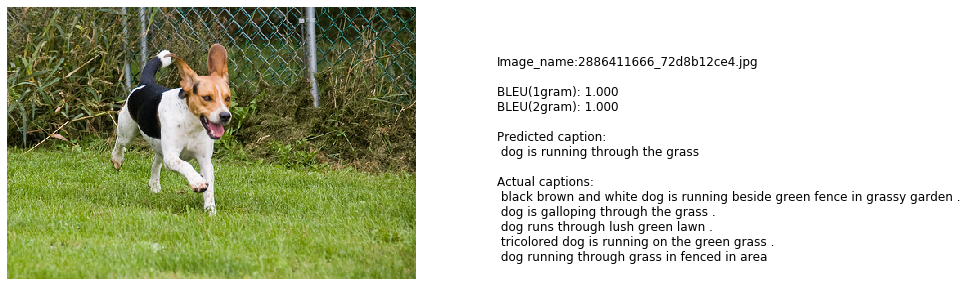

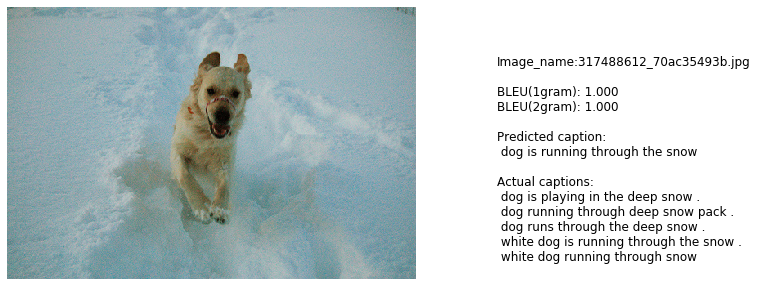

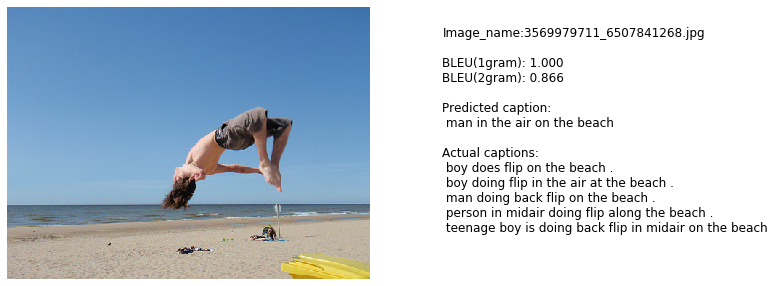

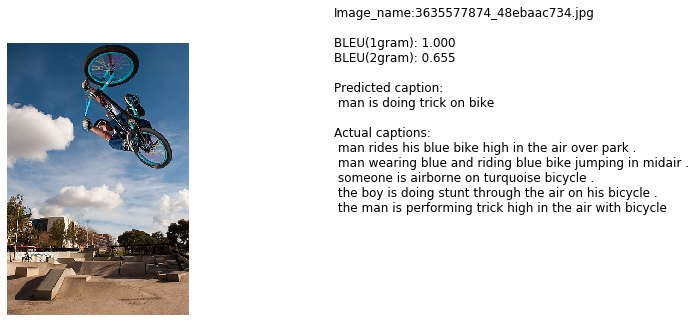

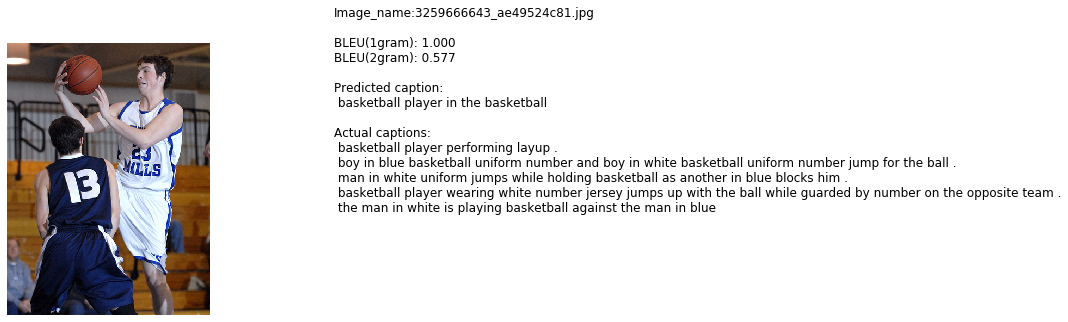

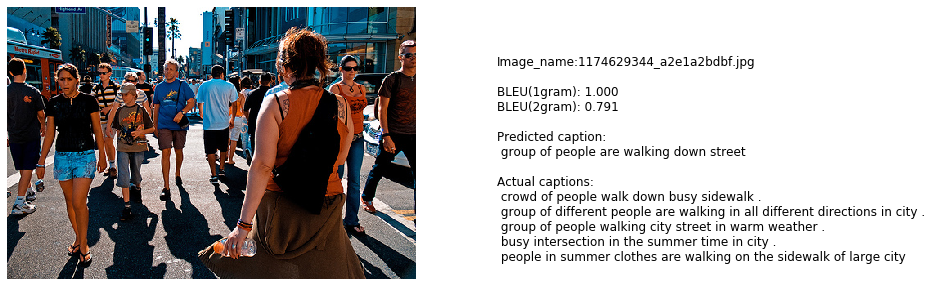

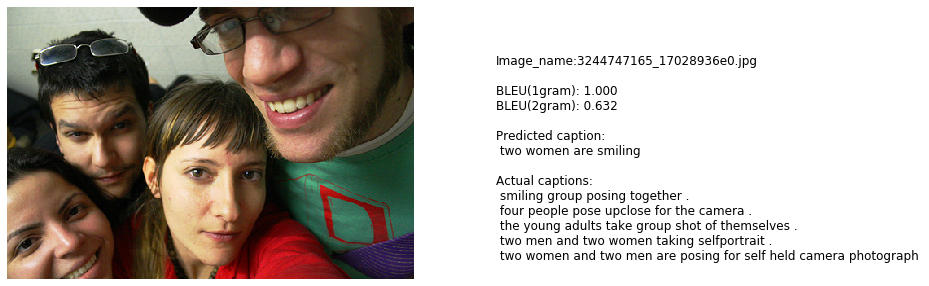

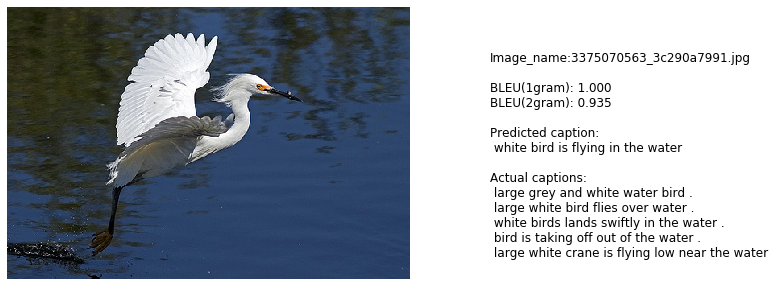

In [150]:
# Display images with highest BLEU scores.
for image in df.sort_values('bleu_2gram', ascending=False)['image_name'].head(2):
    plot_image(image)
    
for image in df[~df['try_actual_final'].str.contains('dog')].sort_values('bleu_1gram', ascending=False)['image_name'].head(6):
    plot_image(image)

# Bad captions

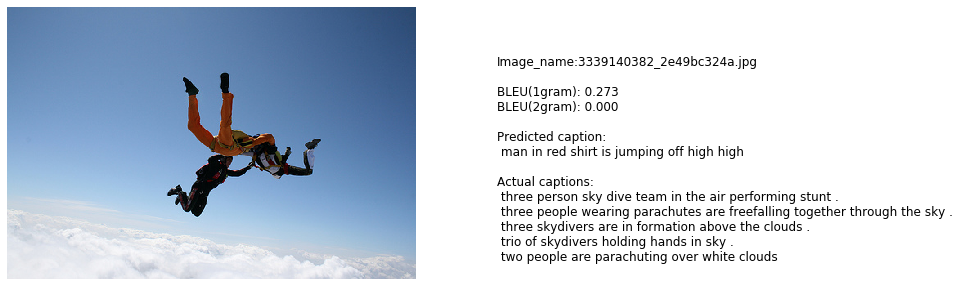

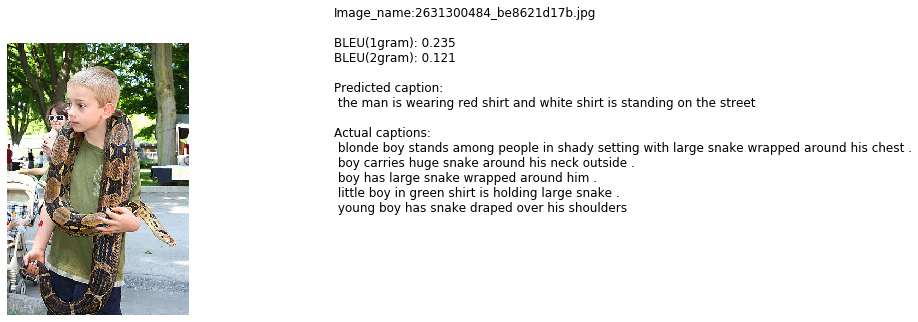

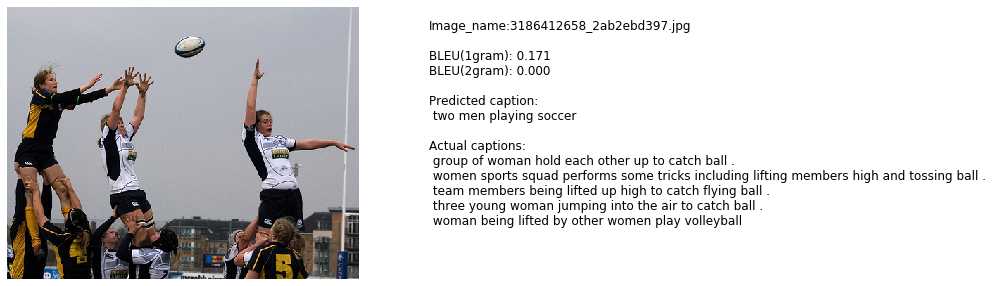

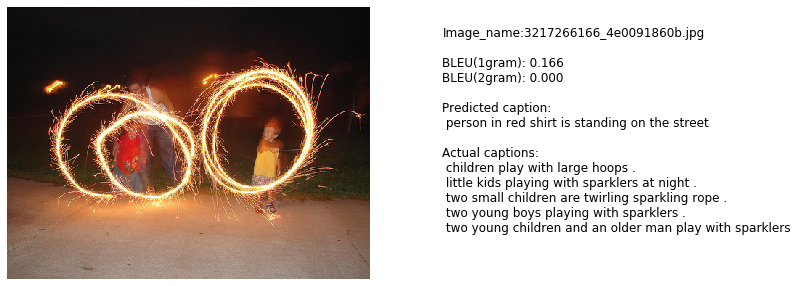

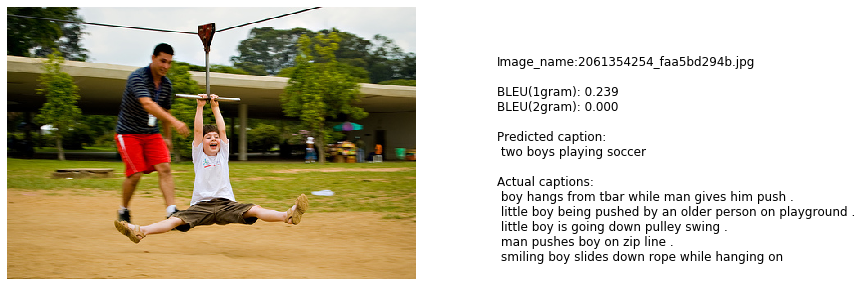

In [151]:
# provide filenames for least performace
for image in df[(df['bleu_1gram']>0.1) & (df['bleu_1gram']<0.3)]['image_name'].head():
    plot_image(image)